## Background & Motivation

Mahjong is a tile-based game that was developed in the 19th century in China and has spread
throughout the world since the early 20th century. The game and its regional variants are widely played
throughout East and Southeast Asia. Some of the interests in playing Mahjong are served for gambling,
socializing, and entertaining, while the main attractiveness behind is to figure out rules out of chaos.

As all of us are Mahjong players, we would like to make the mahjong game a little bit easier by
applying some AI techniques to make decisions for us. In decision-making, the understanding of the
current situation is crucial, which motivates us with the idea to try to identify all Mahjong tiles on deck. It
allows a full appreciation of what tiles we have and what tiles are in the pool and discarded.

Our proposal is to implement a classification project to distinguish different Mahjong tiles on the
deck. The project involves several stages, from image information extraction to model parsing, labeling,
and output classification. We will parse the input images from the Japanese mahjong game application
雀魂麻将 (Maj Souls) as the source of the dataset.

This project is aiming for Japanese mahjong games, which will be slightly different from Chinese mahjong. 
The tiles in Maj Souls can be divided into four different types, Wan, Tiao, Tong, and Character. 
The first three types each have nine different tile
representations, ranging from number one to nine. The last type of Character includes seven distinct
tiles, namely Dong, Xi, Nan, Bei, Zhong, Fa, and Bai. All tiles will add up to 34 different image
representations in total. Our project targets to mainly identify the above 34 different Mahjong images.

We are proposing a model to first train and identify the images we collect from Maj Souls, forming a
dataset of 34 different labels. As the image might be oriented differently or slightly miss certain pixels
and data augmentation methods can be applied to our dataset, our training will include all possible
image conditions. Accuracy of tiles is key to decision-making models, we will aim to achieve around
100% accuracy on validation and test datasets. The logic behind Mahjong is somewhat straightforward,
our model would expand further to implement automated decision-making for players, nevertheless
limited by the timing and resources of our project.

In [4]:
# import required modules
import os
import random
import skimage.io as io
from skimage.transform import resize, rotate
from skimage.util import random_noise, img_as_ubyte
import zipfile
import shutil
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 

## Data Collection

In [5]:
# assign directory
directory_train = './dataset/train'
directory_test = './dataset/test'
output_directory_train = './dataset_preprocessed/train'
output_directory_test = './dataset_preprocessed/test'
# This may cause some error in some operation systems.
skip_list = ['.DS_Store']
k = 2

# Only run once, only when you want to reproduce should set this to True
enable_split = False

# split before data enhancement to avoid data leak
if enable_split:
    for filename in os.listdir(directory_train):
            f = os.path.join(directory_train, filename)
            f_out = os.path.join(directory_test, filename)
            if not os.path.exists(f_out):
                os.makedirs(f_out)
            if os.path.isdir(f):
                samples = random.sample(os.listdir(f), k)
                for p in samples:
                    from_name = os.path.join(f, p)
                    to_name = os.path.join(f_out, p)
                    shutil.move(from_name, to_name)


## Data Exploration (Raw)

Let's start with data exploration on raw dataset. The following code cell imports the raw dataset.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(root = directory_train, transform=transform)

Let's start with the first 4 examples and use `matplotlib.pyplot` to see some sample images.

The first 4 examples all belong to label 0.

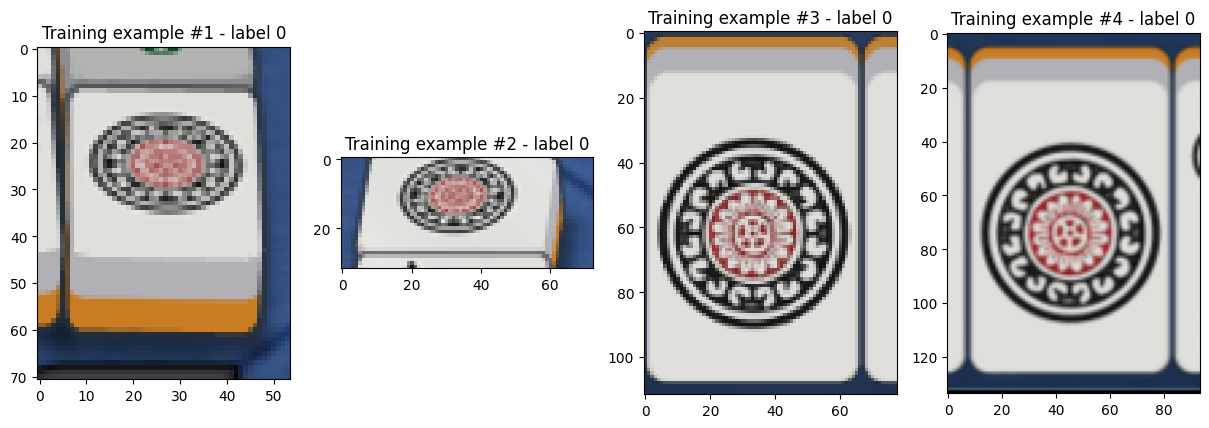

In [7]:
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    axes[i].imshow(dataset[i][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset[i][1]}")

## Data Preprocessing & Data augmentation

In [9]:
# Debug switch
is_debug = False
# we only do preprocessing and augmentation for 1 time because it takes lot of time.
# If want to reproduce, set `enable_preprocessing = True`.
enable_preprocessing = False
# output image size
fix_size = 64

# save image with noise augmentation
def noise_save(name, content):
    io.imsave(name + '-1.png', img_as_ubyte(content))
    image_noised_gaussian = random_noise(content, mode='gaussian', mean=0, var=0.01, clip=True)
    io.imsave(name + '-2.png', img_as_ubyte(image_noised_gaussian))
    image_noised_gaussian_2 = random_noise(content, mode='gaussian', mean=0, var=0.02, clip=True)
    io.imsave(name + '-3.png', img_as_ubyte(image_noised_gaussian_2))
    image_noised_s_p = random_noise(content, mode='s&p', salt_vs_pepper=0.5, clip=True)
    io.imsave(name + '-4.png', img_as_ubyte(image_noised_s_p))
    image_noised_s_p_2 = random_noise(content, mode='s&p', salt_vs_pepper=0.2, clip=True)
    io.imsave(name + '-5.png', img_as_ubyte(image_noised_s_p_2))

# save image with rotation augmentation
def rotate_save(name, content):
    noise_save(name + '-1', content)
    content = rotate(content, 90)
    noise_save(name + '-2', content)
    content = rotate(content, 90)
    noise_save(name + '-3', content)
    content = rotate(content, 90)
    noise_save(name + '-4', content)

map_dirs = [
    [directory_train, output_directory_train],
    [directory_test, output_directory_test],
]

if enable_preprocessing:
    # iterate over files in that directory
    for dir in map_dirs:
        for filename in os.listdir(dir[0]):
            f = os.path.join(dir[0], filename)
            f_out = os.path.join(dir[1], filename)
            if not os.path.exists(f_out):
                os.makedirs(f_out)
            if os.path.isdir(f):
                for imgname in os.listdir(f):
                    if (imgname in skip_list):
                        continue
                    img = os.path.join(f, imgname)
                    img_raw = io.imread(img)
                    # Resize all data to fix size
                    image_resized = resize(img_raw, (fix_size, fix_size), anti_aliasing=True)
                    rotate_save(os.path.join(f_out, imgname[0: imgname.find('.')]), image_resized)
                    if is_debug:
                        io.imshow(image_resized)
                        break
            if is_debug:
                break

## Data Exploration (Processed)

Load our data as standard input:

In [10]:
image_size = (64, 64)
batch_size = 32

path = '/tmp/dataset_cs5242'

shutil.rmtree(path, ignore_errors=True)
with zipfile.ZipFile("./dataset_preprocessed.zip", 'r') as zip_ref:
    zip_ref.extractall(path)

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset_train = torchvision.datasets.ImageFolder(root = path + "/dataset_preprocessed/train", transform=transform)
dataset_test = torchvision.datasets.ImageFolder(root = path + "/dataset_preprocessed/test", transform=transform)

One of the first steps when working with a new data set is exploring. The data are jointly collected, labelled and reviewed by all three of the team members to ensure its correctness and practicality.

Our data have been preprocessed and zipped into the file 'dataset_preprocessed.zip'. In the previous data block we have unzipped the data into a temporary directory and we'll do our future research over this.

With that in mind, let's see some descriptions to see some overview of our dataset and take a look at how the samples are represented.

In [11]:
print(f"The size of the full dataset is: {len(dataset)}\n")

print(f"The total class of the full dataset: {dataset.classes}\n")  # classes names

print(f"The index of these classes: {dataset.class_to_idx}\n") # index of classes

The size of the full dataset is: 627

The total class of the full dataset: ['1b', '1t', '1w', '2b', '2t', '2w', '3b', '3t', '3w', '4b', '4t', '4w', '5b', '5t', '5w', '6b', '6t', '6w', '7b', '7t', '7w', '8b', '8t', '8w', '9b', '9t', '9w', 'bai', 'bei', 'dong', 'fa', 'nan', 'xi', 'zhong']

The index of these classes: {'1b': 0, '1t': 1, '1w': 2, '2b': 3, '2t': 4, '2w': 5, '3b': 6, '3t': 7, '3w': 8, '4b': 9, '4t': 10, '4w': 11, '5b': 12, '5t': 13, '5w': 14, '6b': 15, '6t': 16, '6w': 17, '7b': 18, '7t': 19, '7w': 20, '8b': 21, '8t': 22, '8w': 23, '9b': 24, '9t': 25, '9w': 26, 'bai': 27, 'bei': 28, 'dong': 29, 'fa': 30, 'nan': 31, 'xi': 32, 'zhong': 33}



Here I choose `index=0` to look at the very first sample. We first notice `dataset[0][1]=0`, meaning this entry is the type `0` - '1b'. We will confirm this shortly by visualizing some of these samples. We then notice each entry is an integer ranging from `0-1.0`. This representation is uncommon when working with images since they should be within the range of `0-255`. The numerical entries are interpreted as pixel intensities typically shown in gray-scale ranging between `0` (black) and `255` (white). But we use `torchvision.transforms.ToTensor` in our loading process and it will `converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]` according to the document.

In [12]:
index = 0
print(f"feature: {dataset[index][0].shape} - label {dataset[index][1]}")
print(dataset[index][0])
print(f"testset[{index}] range from {torch.min(dataset[index][0])} to {torch.max(dataset[index][0])}.")

feature: torch.Size([3, 71, 54]) - label 0
tensor([[[0.8745, 0.8745, 0.8275,  ..., 0.2000, 0.2000, 0.2000],
         [0.8745, 0.8745, 0.8510,  ..., 0.2039, 0.2039, 0.2039],
         [0.8745, 0.8745, 0.8627,  ..., 0.2078, 0.2078, 0.2118],
         ...,
         [0.0745, 0.0510, 0.0471,  ..., 0.2039, 0.1961, 0.1882],
         [0.0824, 0.1255, 0.1647,  ..., 0.2000, 0.1961, 0.1882],
         [0.1882, 0.2078, 0.2235,  ..., 0.1961, 0.1922, 0.1843]],

        [[0.8745, 0.8745, 0.8275,  ..., 0.3059, 0.3059, 0.3059],
         [0.8745, 0.8745, 0.8510,  ..., 0.3098, 0.3098, 0.3098],
         [0.8745, 0.8745, 0.8627,  ..., 0.3098, 0.3137, 0.3176],
         ...,
         [0.1216, 0.0745, 0.0588,  ..., 0.3216, 0.3176, 0.3059],
         [0.0784, 0.1216, 0.1569,  ..., 0.3216, 0.3176, 0.3059],
         [0.1804, 0.1961, 0.2118,  ..., 0.3137, 0.3098, 0.2980]],

        [[0.8627, 0.8627, 0.8235,  ..., 0.4980, 0.4980, 0.4980],
         [0.8627, 0.8627, 0.8431,  ..., 0.5020, 0.5020, 0.5020],
         [0.862

Let's import `matplotlib.pyplot` to see some sample images.

In [13]:
import matplotlib.pyplot as plt 

Let's start with the first 4 examples.

The first 4 examples all belong to label 0 and some images are generated from data augmentation to obtain better generalization of our model.

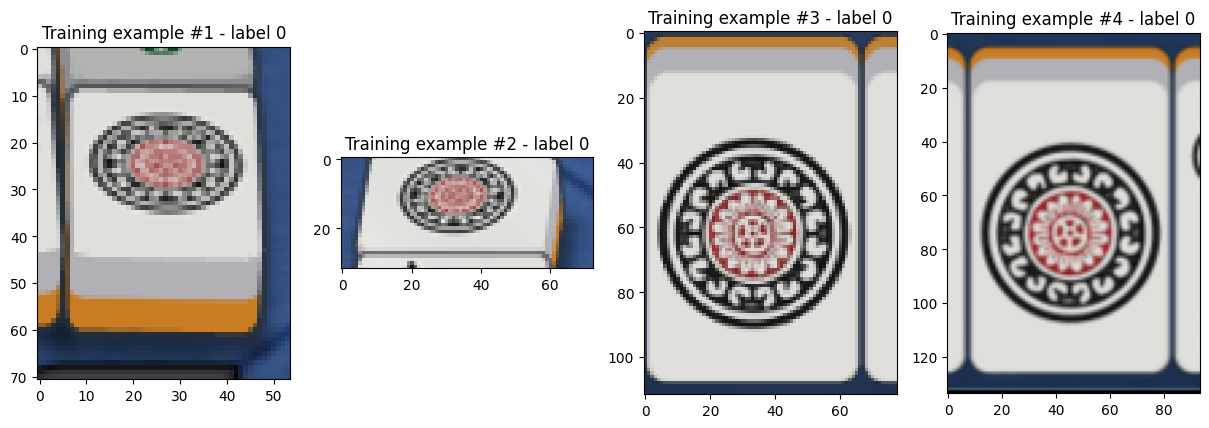

In [14]:
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    axes[i].imshow(dataset[i][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset[i][1]}")

Let's continue to explore some random images.

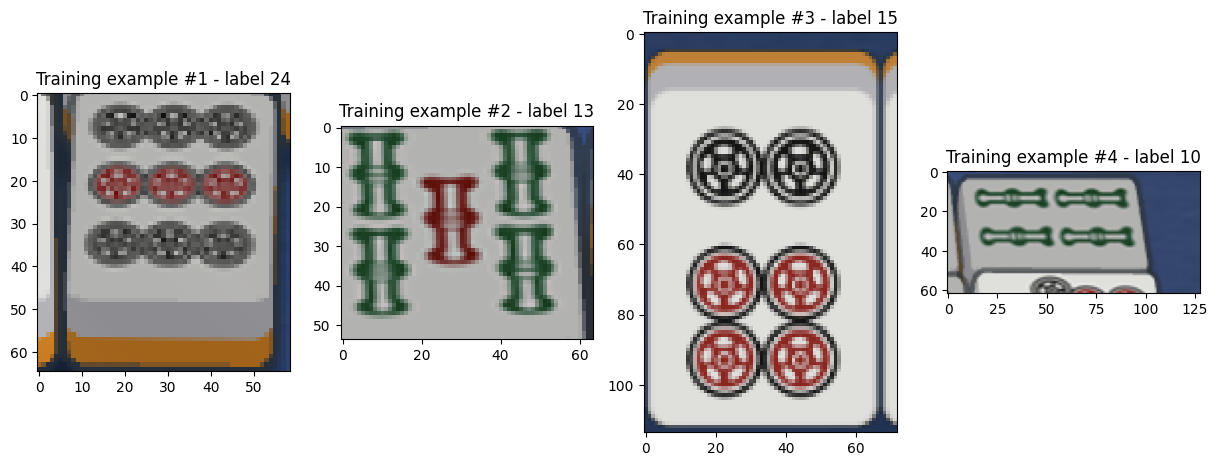

In [15]:
from random import randint
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    value = randint(0, len(dataset))
    axes[i].imshow(dataset[value][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset[value][1]}")

## Data split

We already split our data to training set and validation set. Simply load them from our preprocessed data.

In [16]:
# validation_set_ratio = 0.2
batch_size = 32
n = len(dataset)  # total number of examples
# n_test = int(validation_set_ratio * n)
# subsets = torch.utils.data.random_split(dataset, [n - n_test, n_test], generator=torch.Generator().manual_seed(42))
# train_set = subsets[0]
# test_set = subsets[1]
# print(train_set.__len__(), test_set.__len__()) # [train_set, validation_set]
# print(type(train_set.dataset))

train_data_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=0)
train_data_loader
test_data_loader = DataLoader(dataset_test, batch_size, shuffle=True, num_workers=0)
test_data_loader

In [17]:
# Sample for using the above data loaders
for i, data in enumerate(train_data_loader, 0):
    # iteration index, torch.Size([32, 64, 64, 3]) torch.Size([32])
    print(i, data[0].permute(0, 2, 3, 1).shape, data[1].shape)
    break

0 torch.Size([32, 64, 64, 3]) torch.Size([32])


## MLP Baseline

## Resnet

In [18]:
import datetime
import gc
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.models import resnet50

def getTimeStamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")

# parameters
weight_save_path = 'weight-resnet50-' + getTimeStamp()
num_epoch = 1
lr = 0.001
lr_decay_gamma = 0.8

# prepare model for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = resnet50()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=lr_decay_gamma, verbose=True)

# train the model
for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print('epoch {:3d} | {:5d} batches loss: {:.7f}'.format(epoch, i + 1, running_loss / 10))
            running_loss = 0.0
            torch.save(model.state_dict(), weight_save_path)
        gc.collect()
    scheduler.step()

print('Finished Training, the model weights are saved in {}'.format(weight_save_path))

Adjusting learning rate of group 0 to 1.0000e-03.
epoch   0 |    10 batches loss: 4.8890185
epoch   0 |    20 batches loss: 4.0245129


KeyboardInterrupt: 

In [35]:
model.load_state_dict(torch.load(weight_save_path))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 66 %


## Garbage Collection

Let's do some clean up before finish.

In [12]:
shutil.rmtree(path, ignore_errors=True)

## Model Comparison

## Analysis and Conclusion

## Future Thoughts

## Appenix